## I. CLUSTER DYNAMICS

### Numerical Implementation
The numerical implementation of the TF model follows the approach of Kelton, Greer, and Thompson[^1] as used in previous works. The cluster size changes via single molecule attachment and detachment, as described by the master equations.

### Master Equations
The rate of change of the number density of *i*-mers is given by:

$$
\frac{dN_i}{dt} = D_{i+1}N_{i+1} + A_{i-1}N_{i-1} - (D_i + A_i)N_i
$$

Where:
- $ N_i $ is the number density of *i*-mers,
- $ i \geq u $, and *u* is the minimum cluster size treated numerically,
- $ A_i $ and $ D_i  4are the rates of single molecule attachment and detachment, respectively.

### Steady State Balance
At steady state ($ \theta = 0 $), the balance is given by:

$$
0 = A_{i-1}N_{eq,i-1} - D_iN_{eq,i+1}
$$

### Equilibrium Number Densities
The equilibrium number densities follow the Boltzmann distribution:

$$
N_{eq,i} = N_1 \exp\left(-\frac{W_i}{kT}\right)
$$

Where:
- $ W_i $ is the free energy of formation of the *i*-mer,
- $ k $ is the Boltzmann's constant,
- $ T $ is the temperature.

### Formation Rate of Clusters
The formation rate of clusters is concerned with the net formation rate of clusters of given size and the number density of such clusters. It is expressed as:

$$
J_i = A_iN_i - D_{i+1}N_{i+1}
$$

### Observable Cluster Size
The number of molecules in the cluster of "observable" size is:

$$
N_{>i_o} = \sum_{i=i_o+1}^{\infty} N_i
$$

### Boundary Conditions
The initial and boundary conditions are set as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $ if not stated otherwise.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_i = N_1 \exp\left(-\frac{W_i}{kT}\right) $, where $ W_i = 0 $ as monomers of the parent phase are not distinguishable.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import Nucleation_Dynamics as nd
from extensisq import BS5, SSV2stab, Pr9, CK5, CFMR7osc, Pr7
import scienceplots
import Nucleation_Dynamics as nd
from diffeqpy import de, ode
plt.style.use(['science','ieee'])

For crystal nucleation in melt or glass, the rate of formation, \( A_i \), is expressed as:

$$
A_i = bD\lambda^{-2i/3} \exp\left(-\frac{W_{i+1} - W_i}{2kT}\right)
$$

where:
- $ b = 24 $ is a geometrical factor,
- $D $ is the diffusion coefficient,
- $\lambda $ is the jump distance in the parent phase.

### Initial and Boundary Conditions
The initial and boundary conditions applied are as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_1 = N_L \exp\left(-\frac{W_1}{kT}\right) $, where $ W_1 = 0 $ as monomers of the parent and new phases cannot be distinguished.

The number density of monomers is kept constant at $ N_1(t) = N_{eq,1} $. A "no-depletion" boundary condition is applied for the monomers (lower boundary condition); i.e., their number density is constant. The number of molecules in the system depends on the boundary conditions, with a different upper boundary condition applied to enforce the conservation of supercritical clusters by closing the system at $ i_{max} $ and setting the rate coefficients $ A_{i_{max}} $ and $ D_{i_{max} + 1} $ equal to zero. 


In [ ]:
# Ejemplo de uso de la clase

path = "data/lithium_disillicate.json"

cluster_physics = nd.ClusterPhysics(path)

print(f"Critical radius: {cluster_physics.critical_radius}")
print(f"Critical Gibbs free energy: {cluster_physics.critical_energy_barrier}")
print(f"Critical number of atoms: {cluster_physics.critical_number_of_molecules}")

For simplicity, spherical clusters with a sharp dividing surface, having the same composition as the parent phase, are assumed. Following Gibbs, the reversible work of formation of a cluster of size \( n \), constructed from \( n \) monomers, or molecules, is:

$$
\Delta G_n = n\Delta G' + (36\pi)^{\frac{1}{3}}v^{\frac{2}{3}}n^{\frac{2}{3}}\sigma ,
$$

where $ \Delta G' $ is the Gibbs free energy per molecule of the new phase less that of the initial phase, $ v $ is the molecular volume and $ \sigma $ is the interfacial energy per unit area. The surface energy penalty is dominant for small clusters, leading to a maximum in $ \Delta G_n $ at the critical size, $ n* $,

$$
n* = \frac{32\pi \sigma^3}{3v|\Delta G_v|^3} ,
$$

where $ \Delta G_v $ is the free energy difference per unit volume, $ \Delta G'/v $. Since clusters smaller than $ n* $ will on average shrink, while those larger than $ n* $ will on average grow, the nucleation rate is in a crude sense the production of postcritical clusters. Clusters are assumed to evolve in size by a series of bimolecular reactions.


In [10]:
MAX_NUMBER_MOLECULES = int(40)
number_clusters_start = 2
steps = int(1e5)
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e6

In [5]:
sim = nd.JuliaClusterDynamics(path,int(1e8),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method = de.Tsit5(), rtol = 1e-5, atol = 1e-5)


NameError: name 'de' is not defined

In [5]:
sim = nd.ScipyClusterDynamics(path,int(2e5),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method=Pr7, t_eval=None, rtol=1e-9, atol=1e-9, max_step = 2*dt)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/extensisq/common.py:452: UserWarning: Your problem has a real dominant root and is diagnosed as stiff.  You should probably change to a code intended for stiff problems.
  warn('Your problem has a real dominant root '


{'execution_time': 24.1949520111084, 'success': True, 'nfev': 1760033}


In [11]:
t_span = (0.0, dt*int(steps))

t_eval = [dt, 10*dt, 1e2*dt, 1e3*dt, 1e4*dt, 1e5*dt]

In [12]:
t_eval = np.linspace(*t_span, int(1e5))
sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)

sim2 = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES, boundary_type="open")
sim2.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)



{'execution_time': 1.8857345581054688, 'success': True, 'nfev': 11848}
{'execution_time': 1.8709442615509033, 'success': True, 'nfev': 11750}


In [36]:
cluster_physics.unbiased_jump_rate

1.1384552476603375e-06 <Unit('1 / second')>

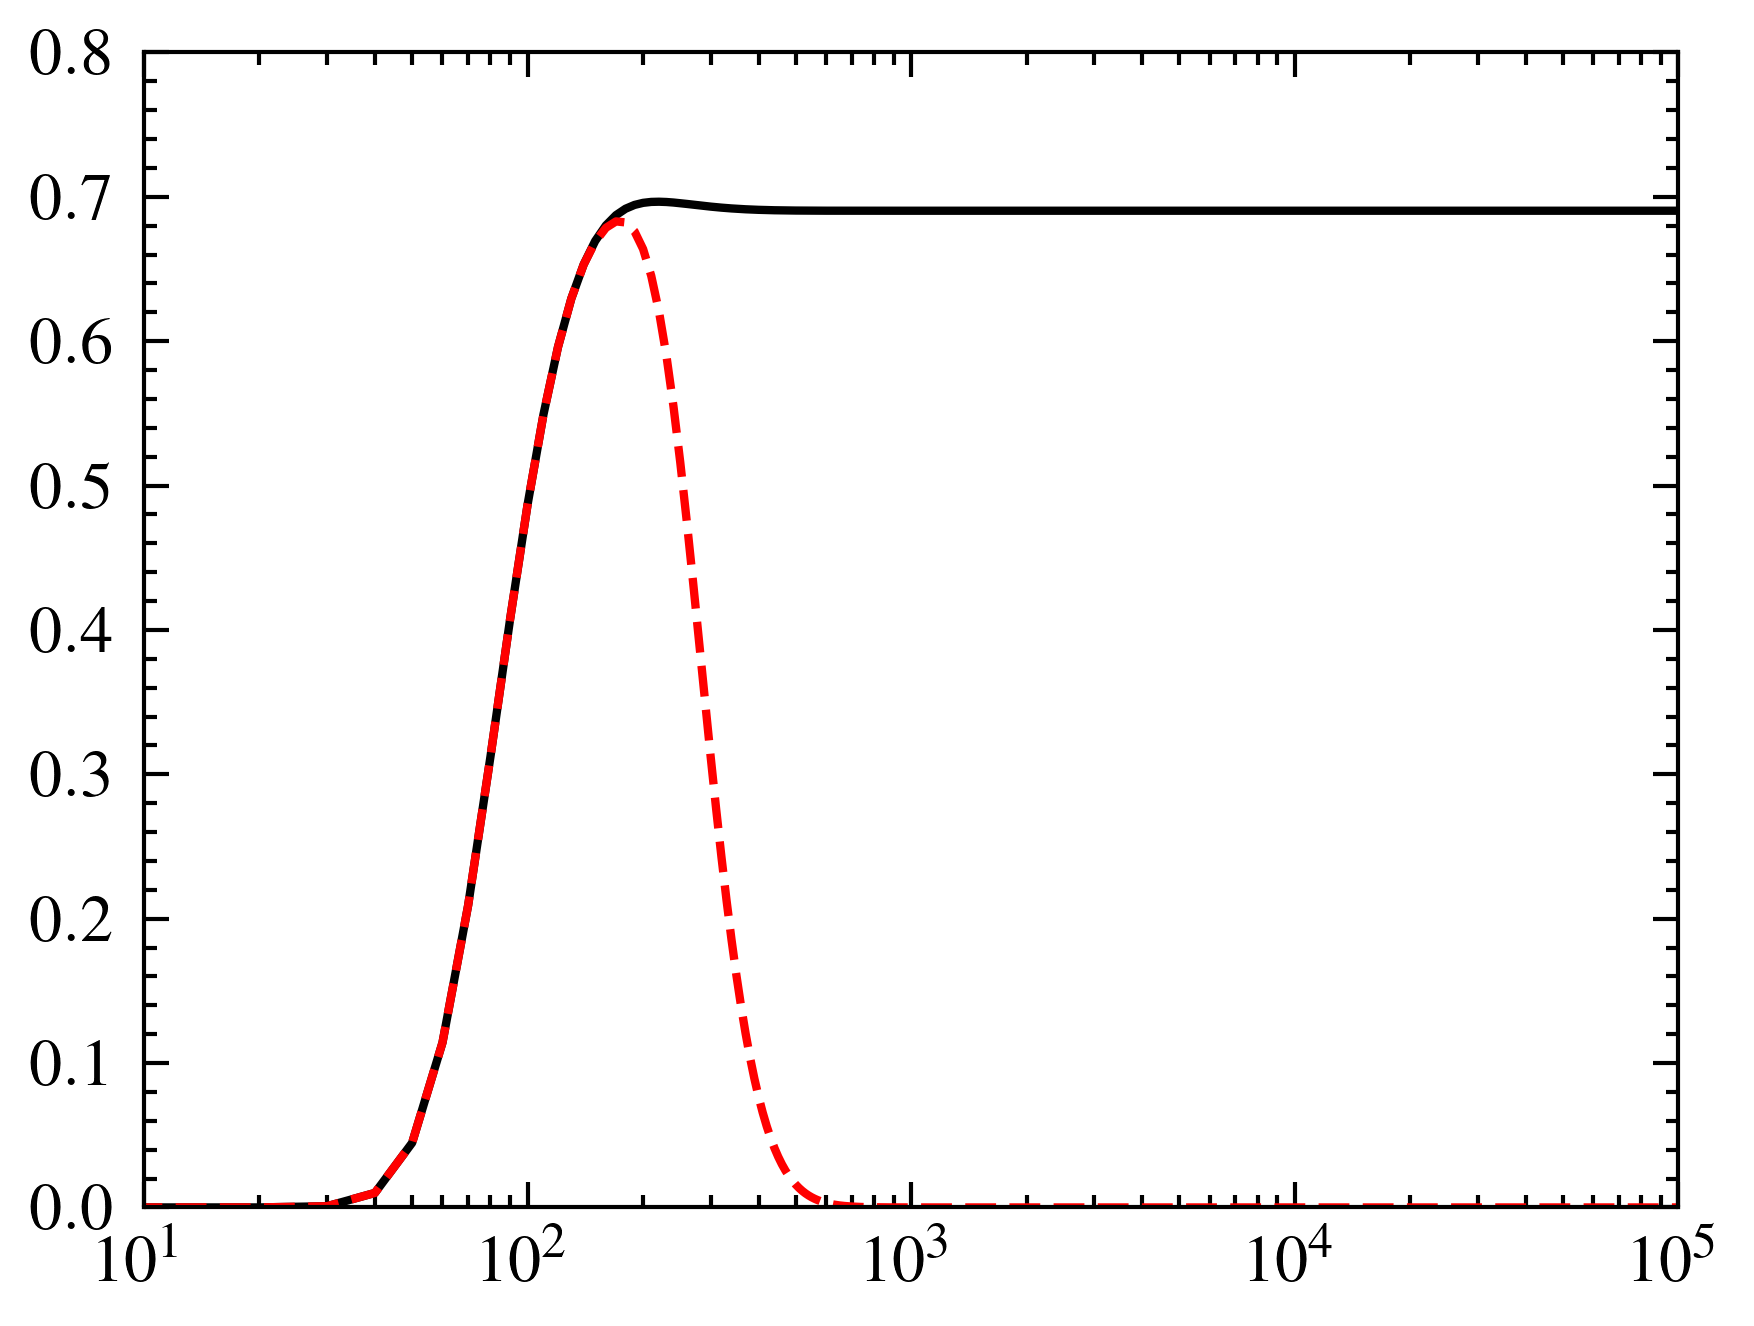

In [7]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.time/dt, 1e-5*sim.dydt_array[22:, :].sum(axis=0)*dt)

plt.plot(sim2.time/dt, 1e-5*sim2.dydt_array[22:, :].sum(axis=0)*dt)

##plt.yscale('log')
plt.xlim(1e1,1e5)
plt.ylim(0, 0.8)
plt.xscale('log')
#plt.yscale('log')
#plt.yscale('log')

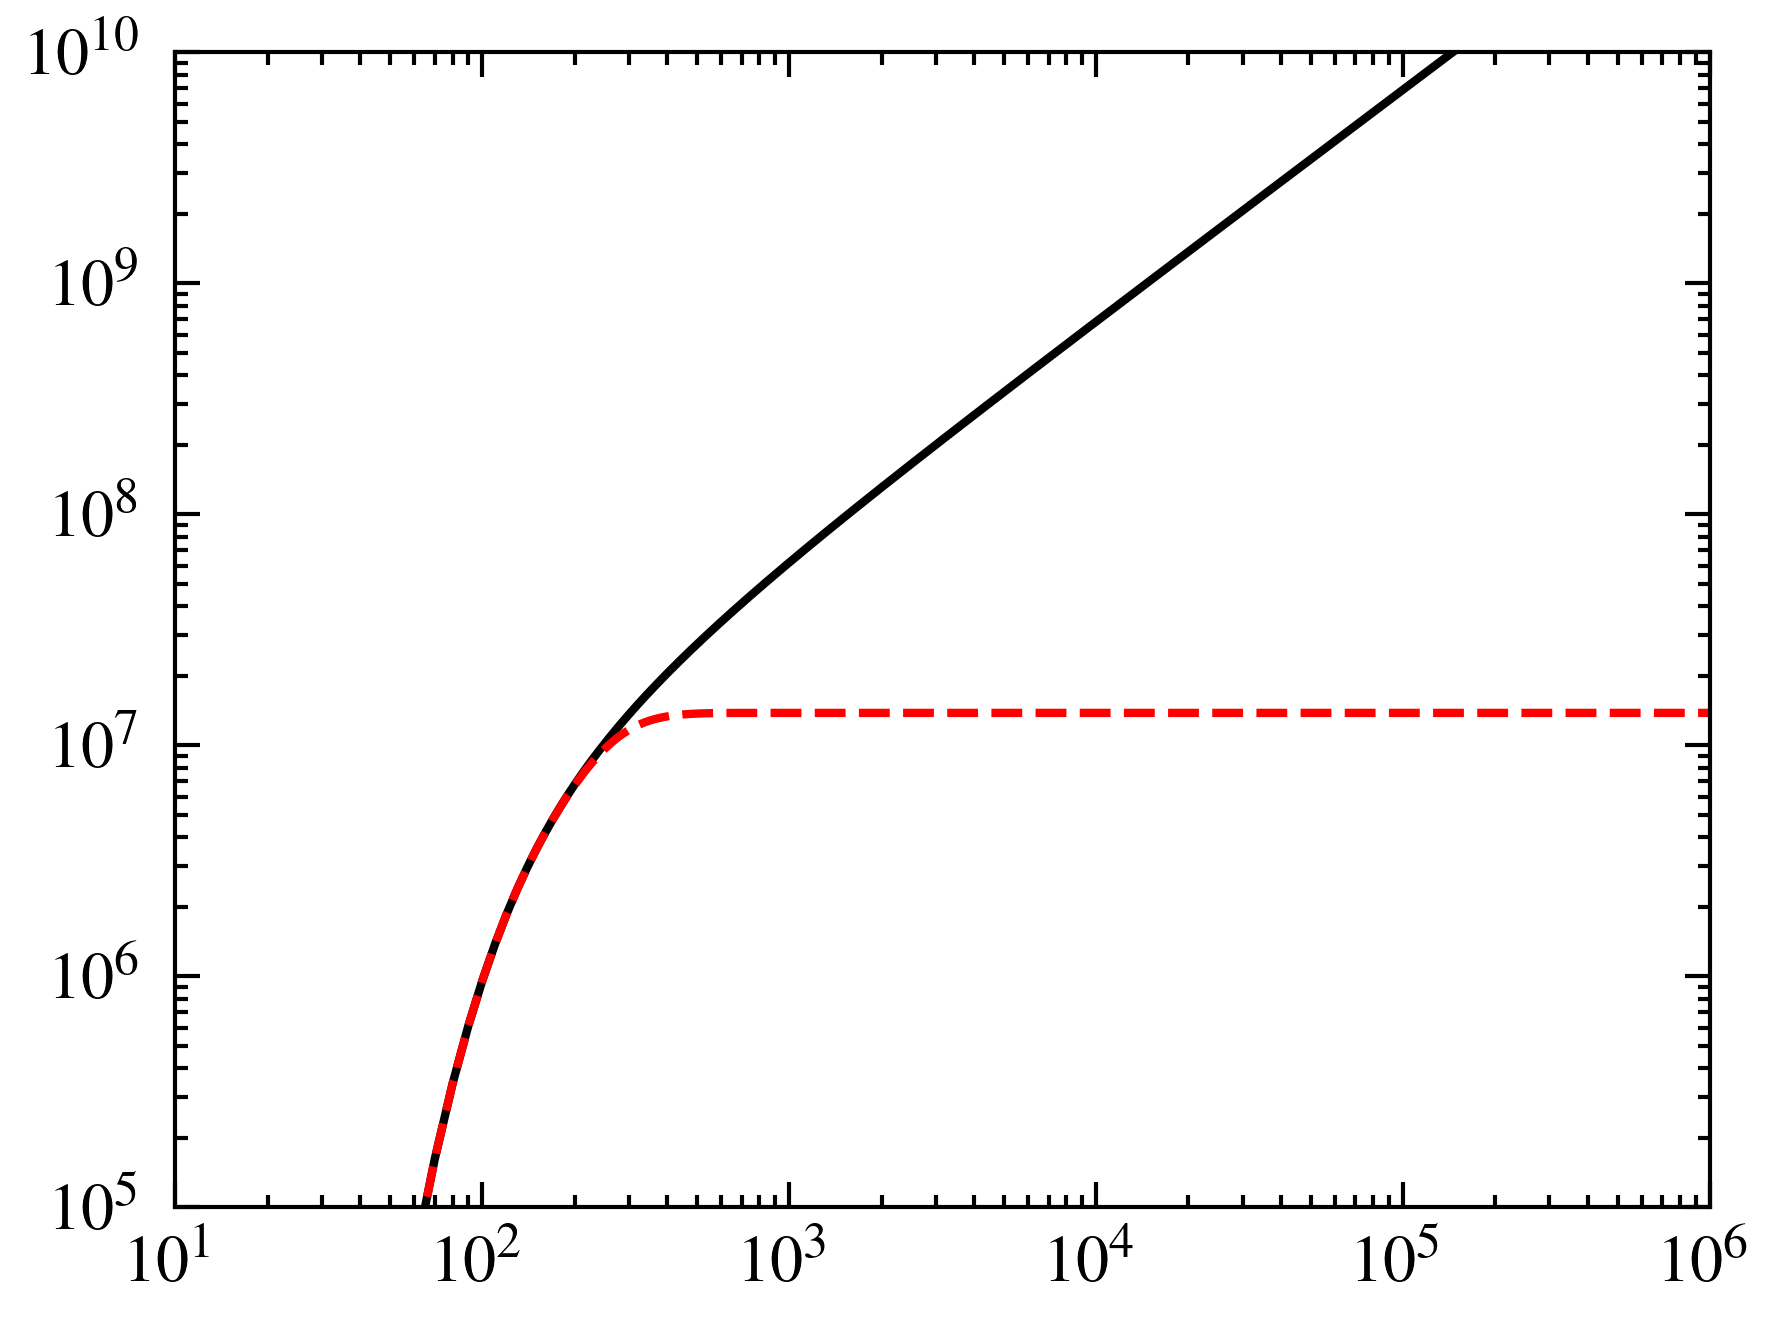

In [8]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.time/dt, sim.cluster_array[23:, :].sum(axis=0))
plt.plot(sim2.time/dt, sim2.cluster_array[23:, :].sum(axis=0))

##plt.yscale('log')
plt.xlim(10,1e6)
plt.ylim(1e5,1e10)
plt.xscale('log')
plt.yscale('log')
#plt.yscale('log')

/tmp/ipykernel_25148/3460223238.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
/tmp/ipykernel_25148/3460223238.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores2 = cm.get_cmap('Greens', 12)  # Contraste claro pero estético para el segundo conjunto
/tmp/ipykernel_25148/3460223238.py:43: RuntimeWarning: divide by zero encountered in log
  plt.plot(number_molecules_array, np.log(sim.cluster_array[:, idx] / 6.022e23),


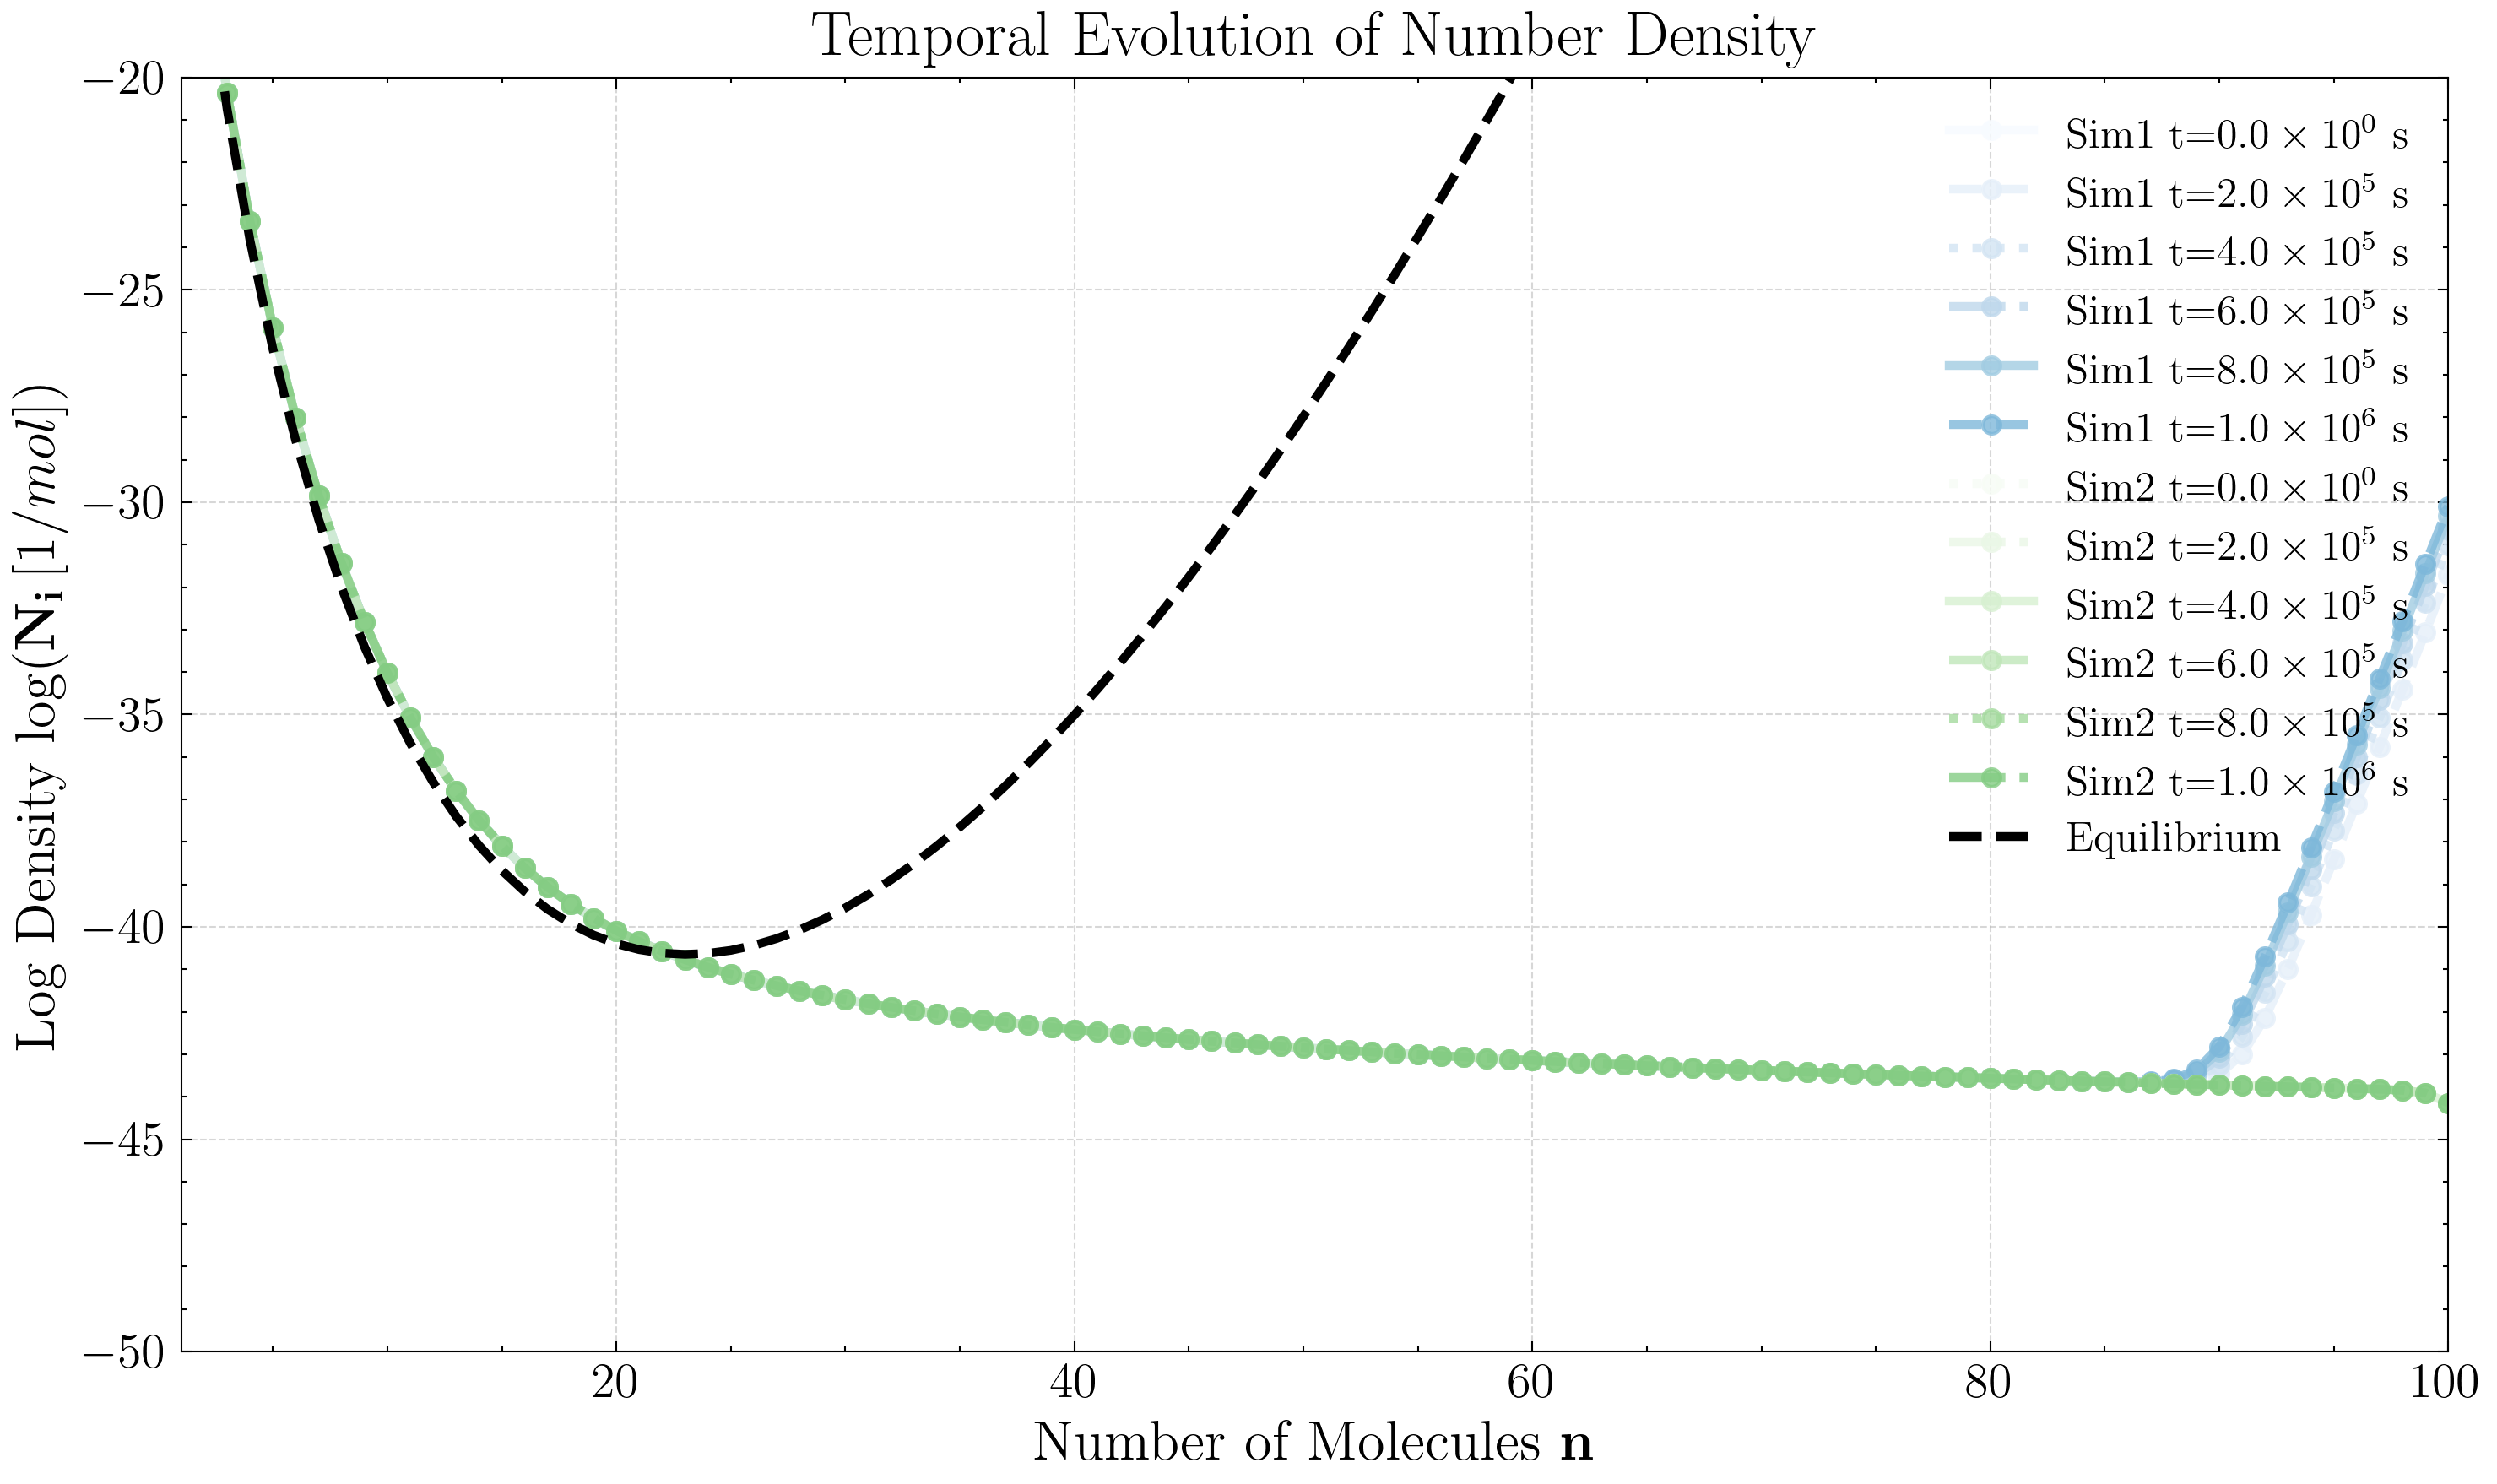

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Definiciones previas omitidas para brevedad

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)

# Mejorar la paleta de colores para una distinción clara y estética
colores1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
colores2 = cm.get_cmap('Greens', 12)  # Contraste claro pero estético para el segundo conjunto

# Ajustes de estilo global mejorados para publicación
plt.rcParams.update({
    'legend.loc': 'upper right',
    'lines.linewidth': 2.5,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],  # Preferido por muchas revistas científicas
    'figure.figsize': (10, 6),
    'figure.dpi': 300,
    'legend.fontsize': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'text.usetex': True  # Para calidad de publicación; asegúrate de que LaTeX esté instalado
})

def plot_results(sim, colores, label_prefix):
    # Selecciona puntos de tiempo equiespaciados para mostrar
    num_points = 6
    indices = np.linspace(0, len(sim.time) - 1, num_points, dtype=int)

    for i, idx in enumerate(indices):
        time_in_s = sim.time[idx] / dt # cluster_physics.unbiased_jump_rate.magnitude
        mantisa, exponente = f"{time_in_s:.1e}".split('e')
        exponente = int(exponente)
        time_formatted = r"${} \times 10^{{{}}}$".format(mantisa, exponente)
        label = f"{label_prefix} t={time_formatted} s"
        
        plt.plot(number_molecules_array, np.log(sim.cluster_array[:, idx] / 6.022e23),
                 label=label, color=colores(i), marker='o', markersize=5, alpha=0.8)

# Llamar a la función para cada conjunto de resultados con mejoras visuales
plot_results(sim, colores1, "Sim1")
plot_results(sim2, colores2, "Sim2")

# Añadir la línea de equilibrio con estilo mejorado
plt.plot(number_molecules_array, np.log(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
         label="Equilibrium", color='black', linestyle='--', linewidth=2.5)

# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Number of Molecules $\mathbf{n}$", fontsize=16)
plt.ylabel(r"Log Density $\log(\mathbf{N_i} \, [1/mol])$", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, MAX_NUMBER_MOLECULES)
plt.ylim(-50, -20)
plt.yticks(np.arange(-50, -19, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Ligera cuadrícula para mejorar la lectura

plt.show()


In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ScipyClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_array[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 0.0337 seconds
Computation time: 0.0521 seconds
Computation time: 0.1762 seconds
Computation time: 1.0776 seconds
Computation time: 29.4072 seconds


/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

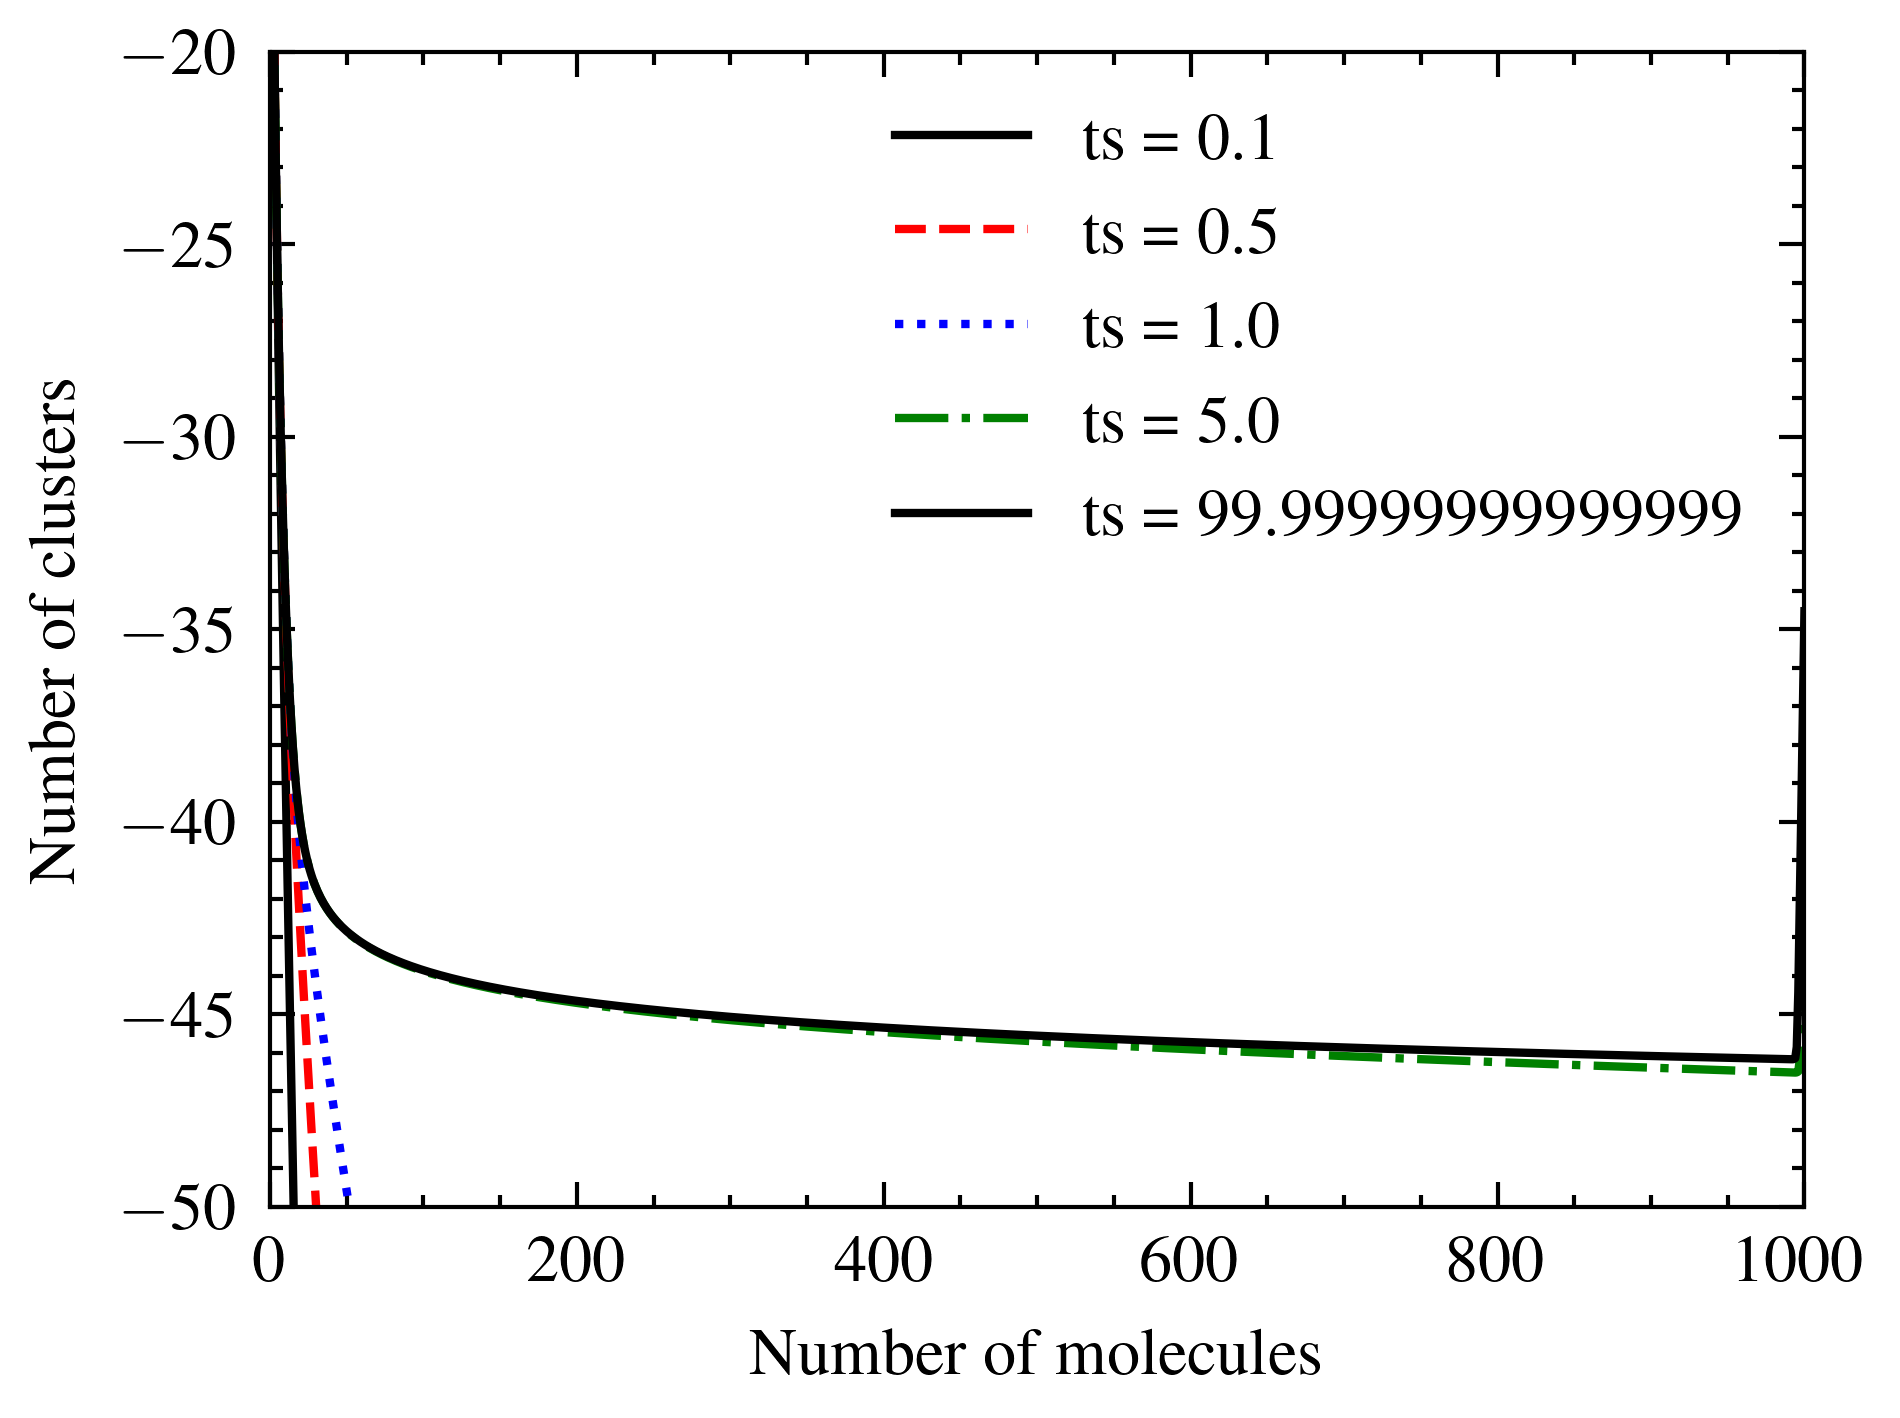

In [6]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.OpenClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=5)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 1.6886 seconds
Computation time: 0.2698 seconds
Computation time: 0.4434 seconds
Computation time: 2.2021 seconds
Computation time: 33.2245 seconds


/tmp/ipykernel_9375/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

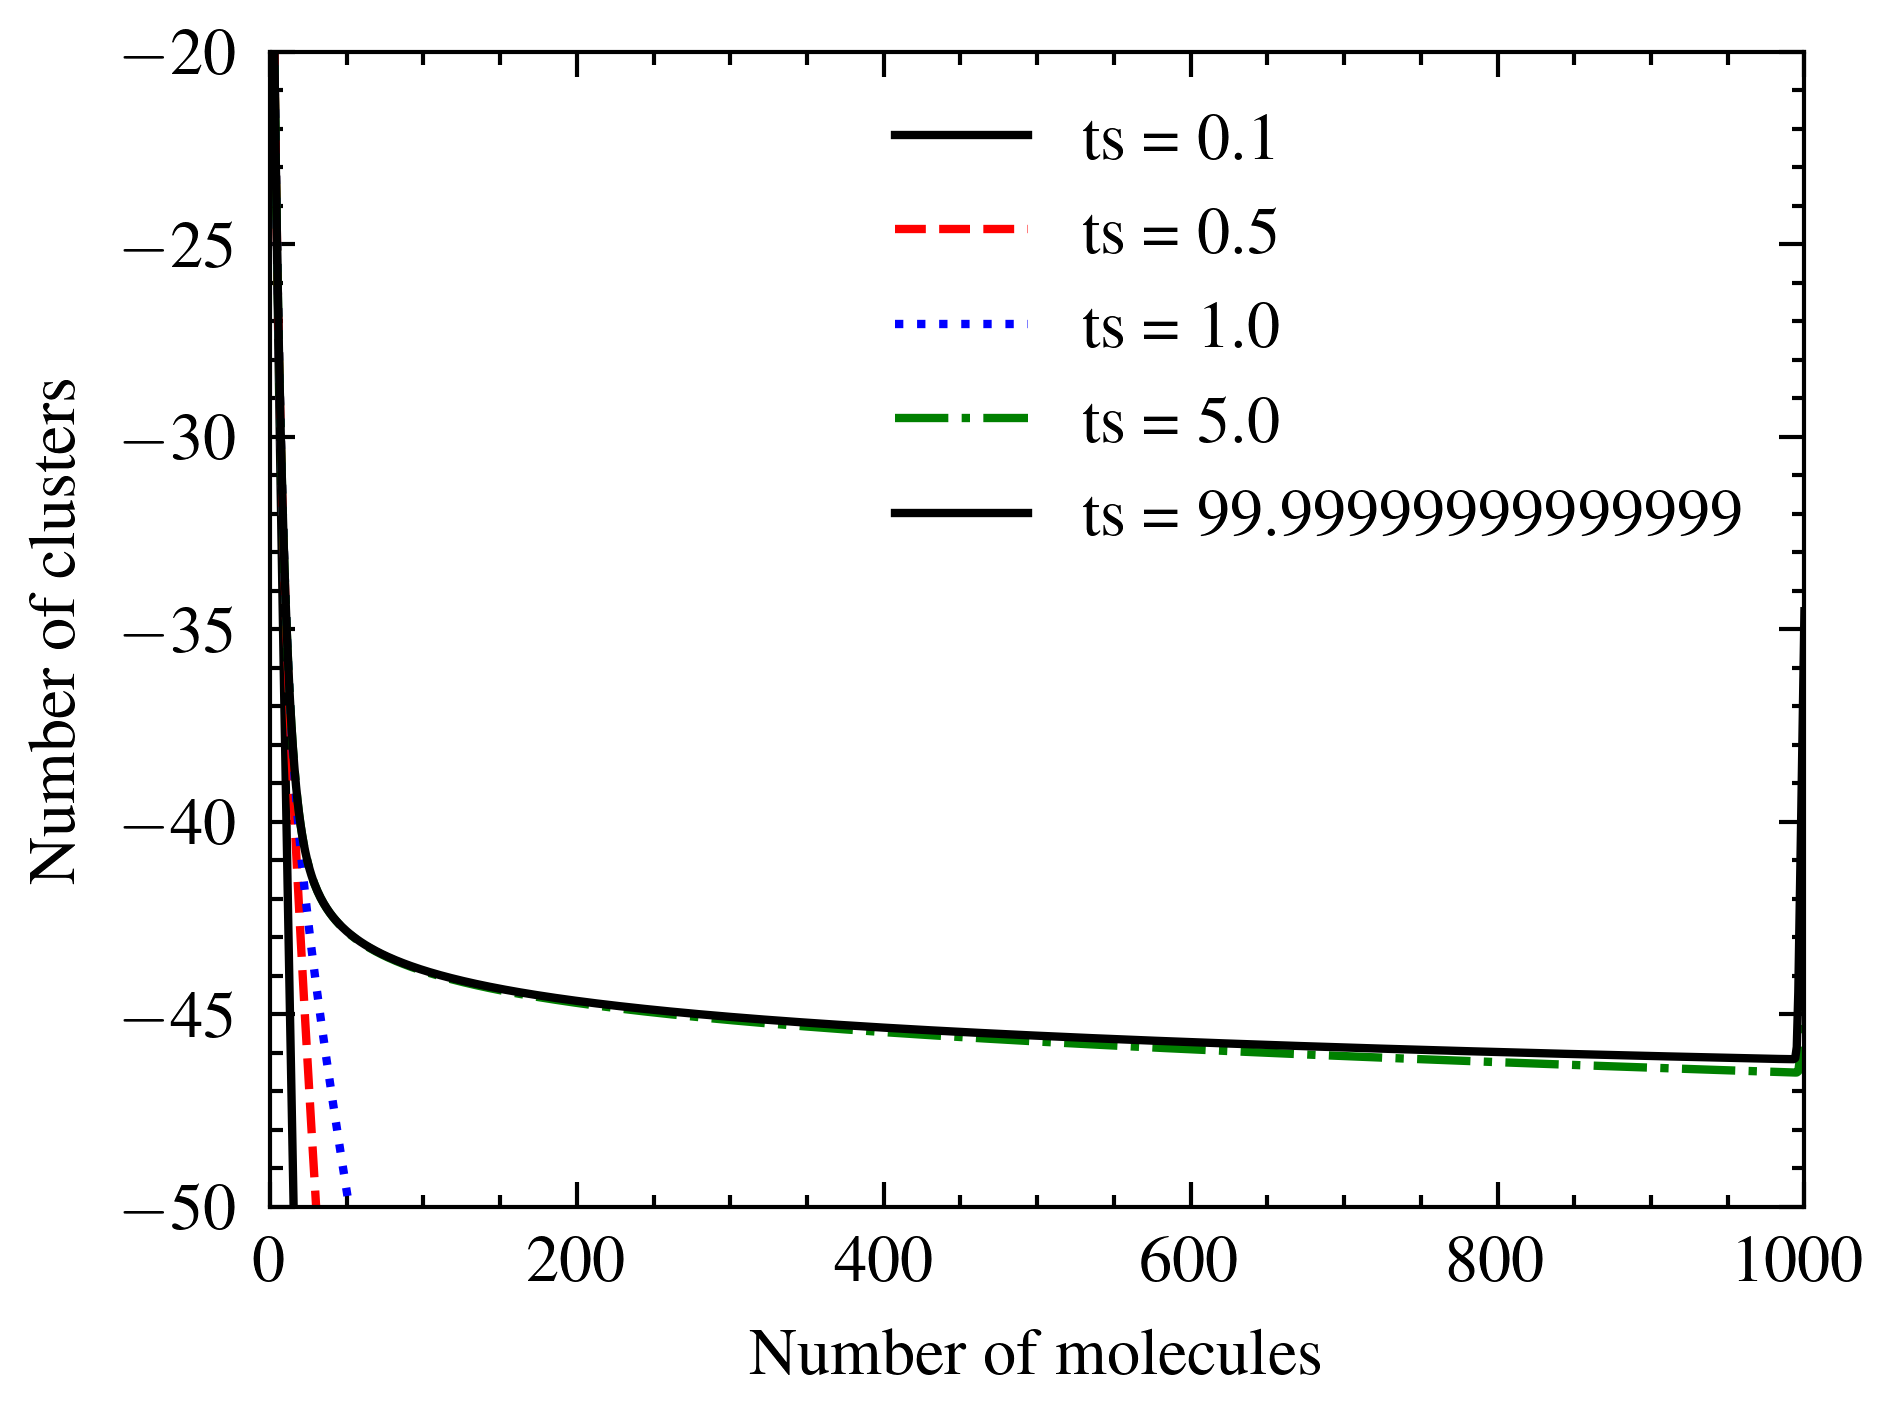

In [8]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [11]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e5)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ClosedClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=1)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

: 

In [9]:
sim.cluster_evolution

array([[5.85658411e+18, 5.85060004e+18, 5.84661418e+18, ...,
                   nan,            nan,            nan],
       [3.16539427e+16, 3.33864363e+16, 3.45252010e+16, ...,
                   nan,            nan,            nan],
       [2.27490565e+14, 3.95465192e+14, 5.18861415e+14, ...,
                   nan,            nan,            nan],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan]])

(0.0, 10000.0)

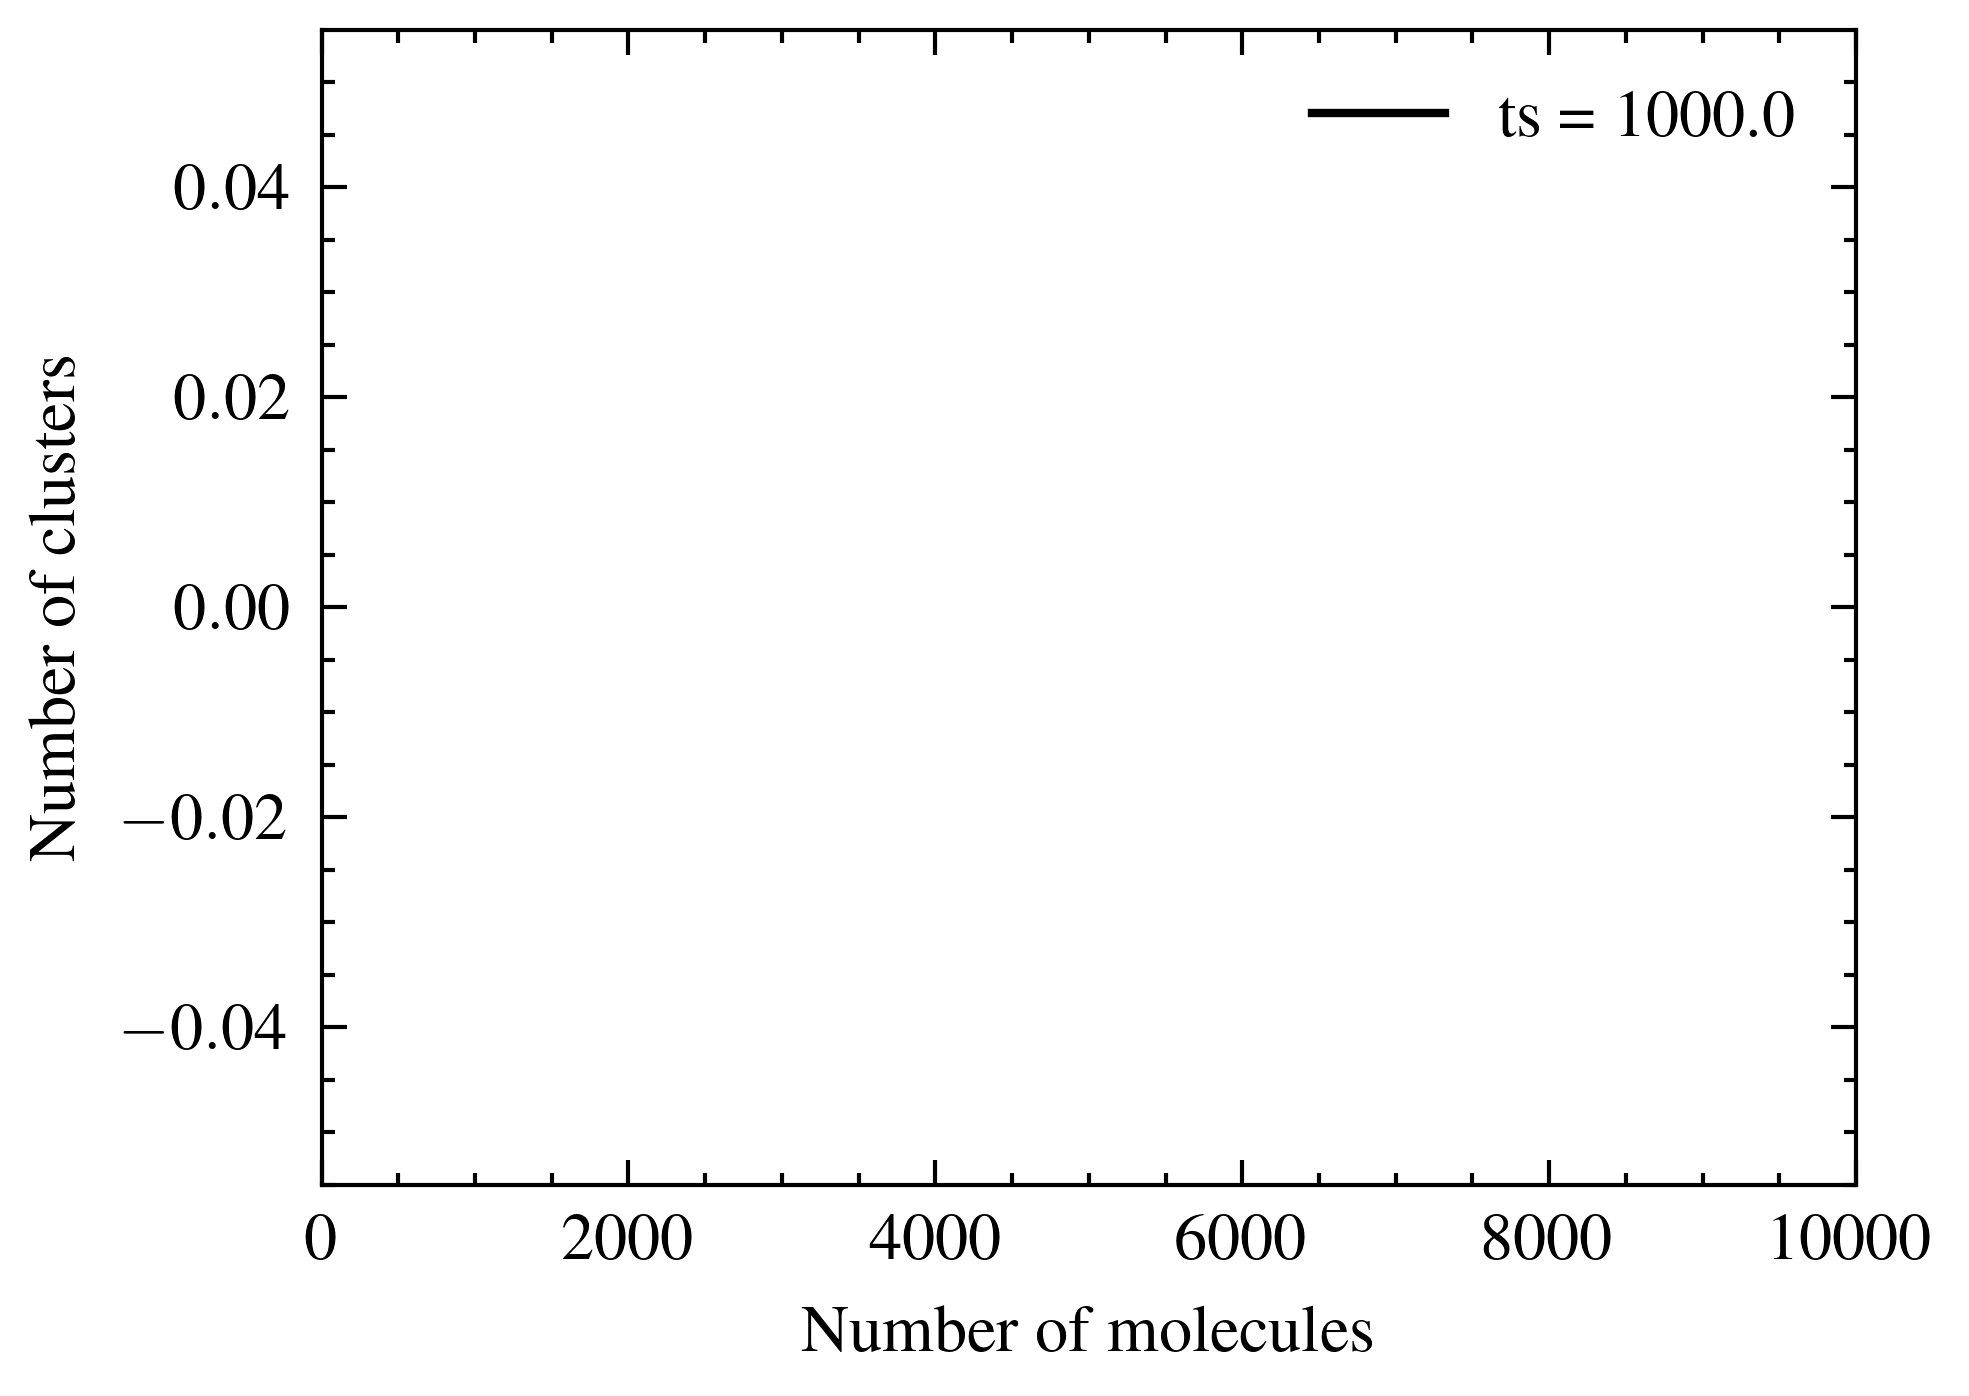

In [8]:
plt.figure()
n = np.linspace(1,100,100)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,10000)
#plt.ylim(-50,-20)

In [7]:
#With Numba 

""" 
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

Computation time: 1.4030 seconds
Computation time: 0.0169 seconds
Computation time: 0.1812 seconds
Computation time: 0.8422 seconds
 """

 # Without Numba
""" 
Computation time: 0.0014 seconds
Computation time: 0.0812 seconds
Computation time: 0.8159 seconds
Computation time: 4.1370 seconds 
"""

' \nComputation time: 0.0014 seconds\nComputation time: 0.0812 seconds\nComputation time: 0.8159 seconds\nComputation time: 4.1370 seconds \n'

In [6]:
steady_state = sim.compute_analytical_steady_state()

(-50.0, -20.0)

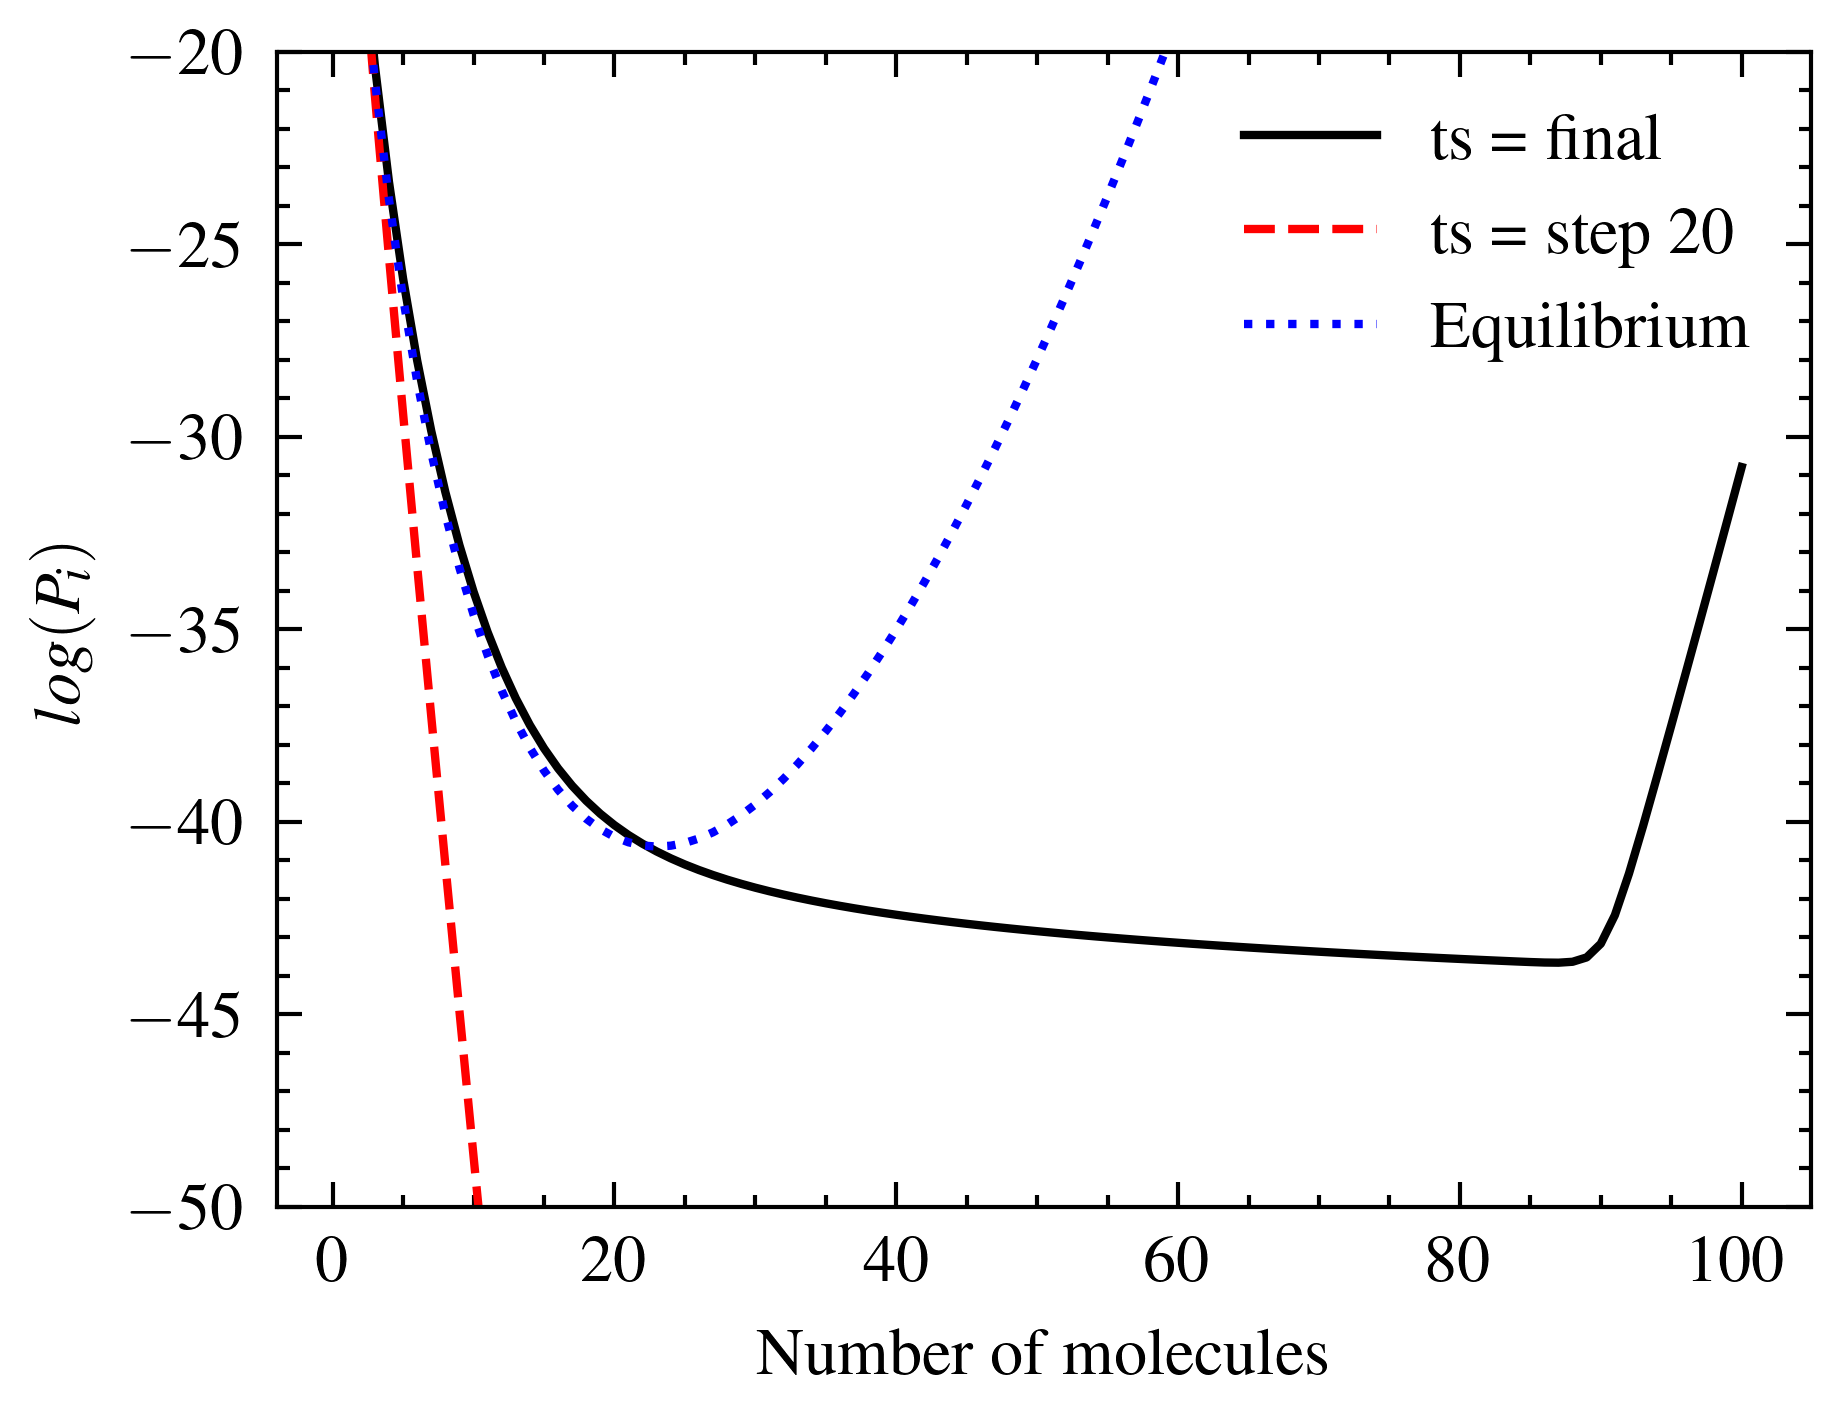

In [8]:

plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


(-50.0, -20.0)

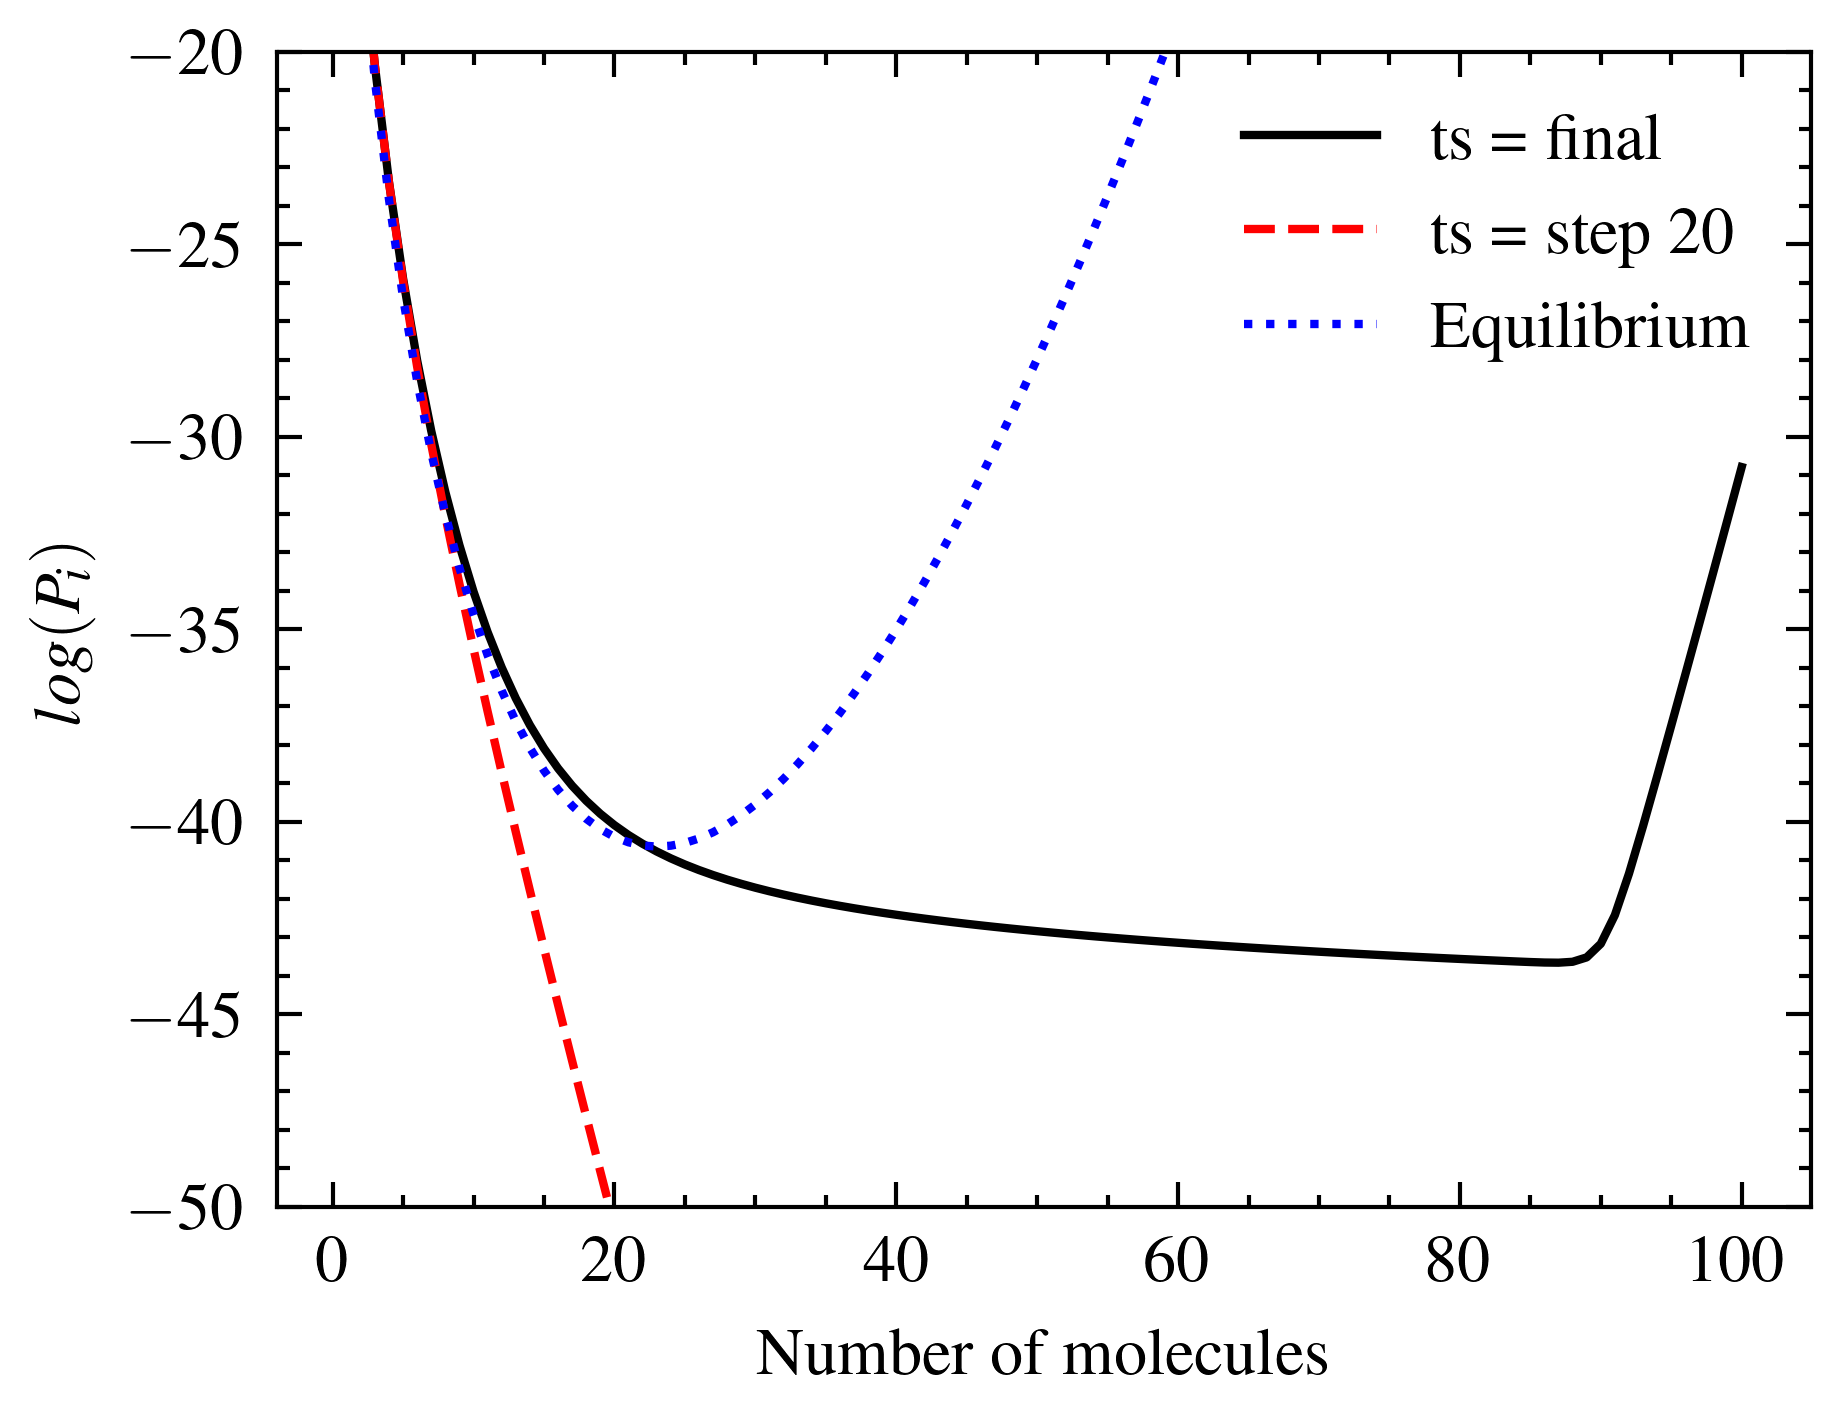

In [6]:
plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


/tmp/ipykernel_31535/2729006377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')


(-50.0, -20.0)

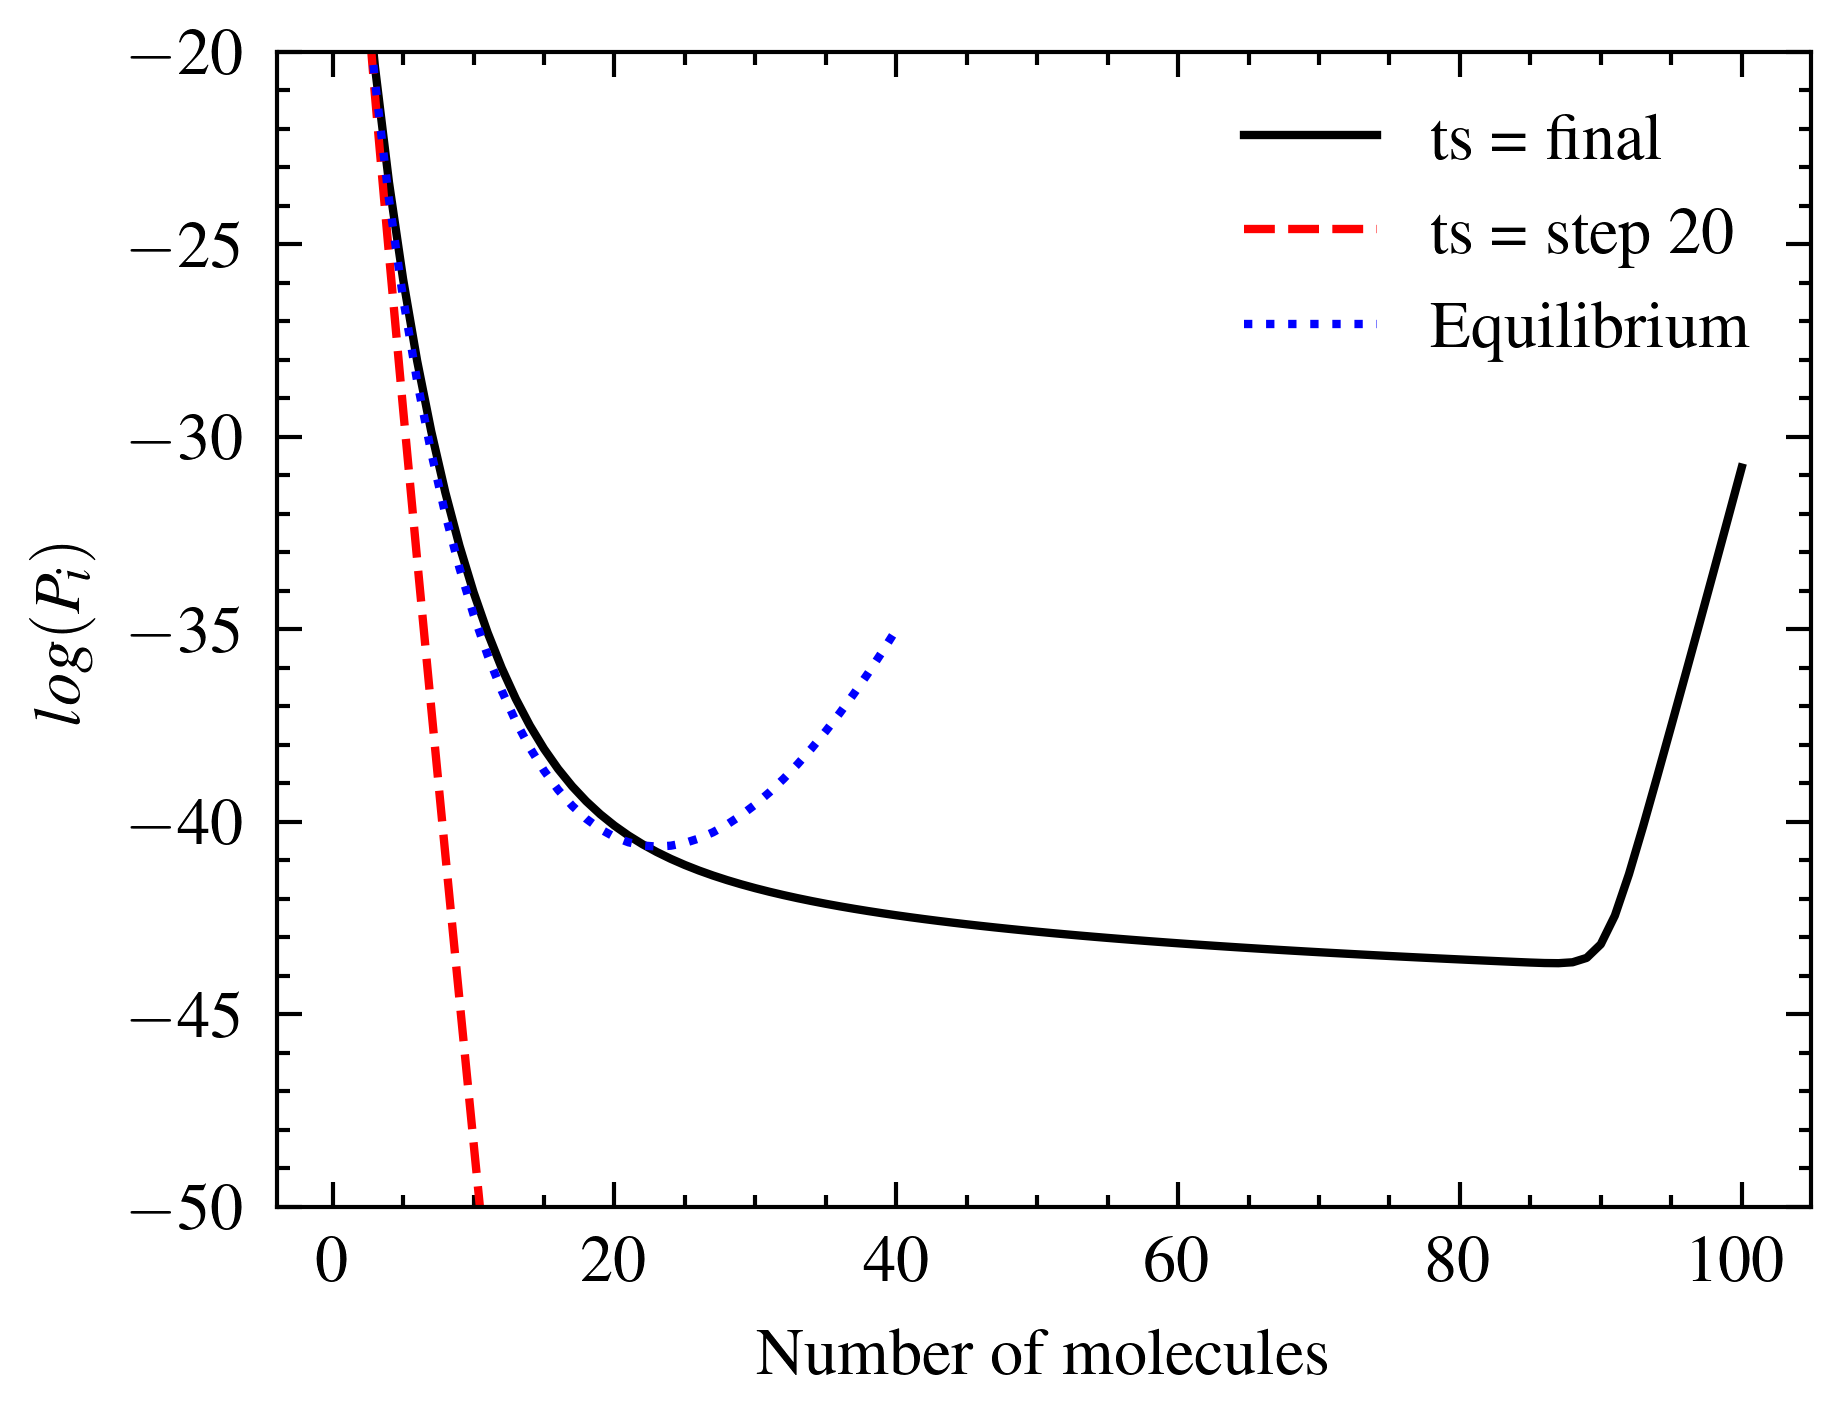

In [8]:
plt.figure()
n = np.linspace(1,40,40)
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


In [9]:
plt.figure()
plt.plot(sim.cluster_evolution[10,:], label = 'N=9')
plt.plot(sim.cluster_evolution[20,:], label = 'N=19')
plt.plot(sim.cluster_evolution[39,:], label = 'N=40')

plt.legend()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Number of clusters')
plt.show()

: 

In [6]:
sim.cluster_evolution

array([[6.02214090e+23, 6.02214090e+23, 6.02214090e+23, ...,
        6.02214090e+23, 6.02214090e+23, 6.02214090e+23],
       [2.95378152e+21, 2.97098365e+21, 2.98782561e+21, ...,
        3.79638202e+21, 3.79638202e+21, 3.79638202e+21],
       [2.67973215e+16, 1.35676791e+18, 2.66750455e+18, ...,
        8.81199288e+19, 8.81199288e+19, 8.81199288e+19],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

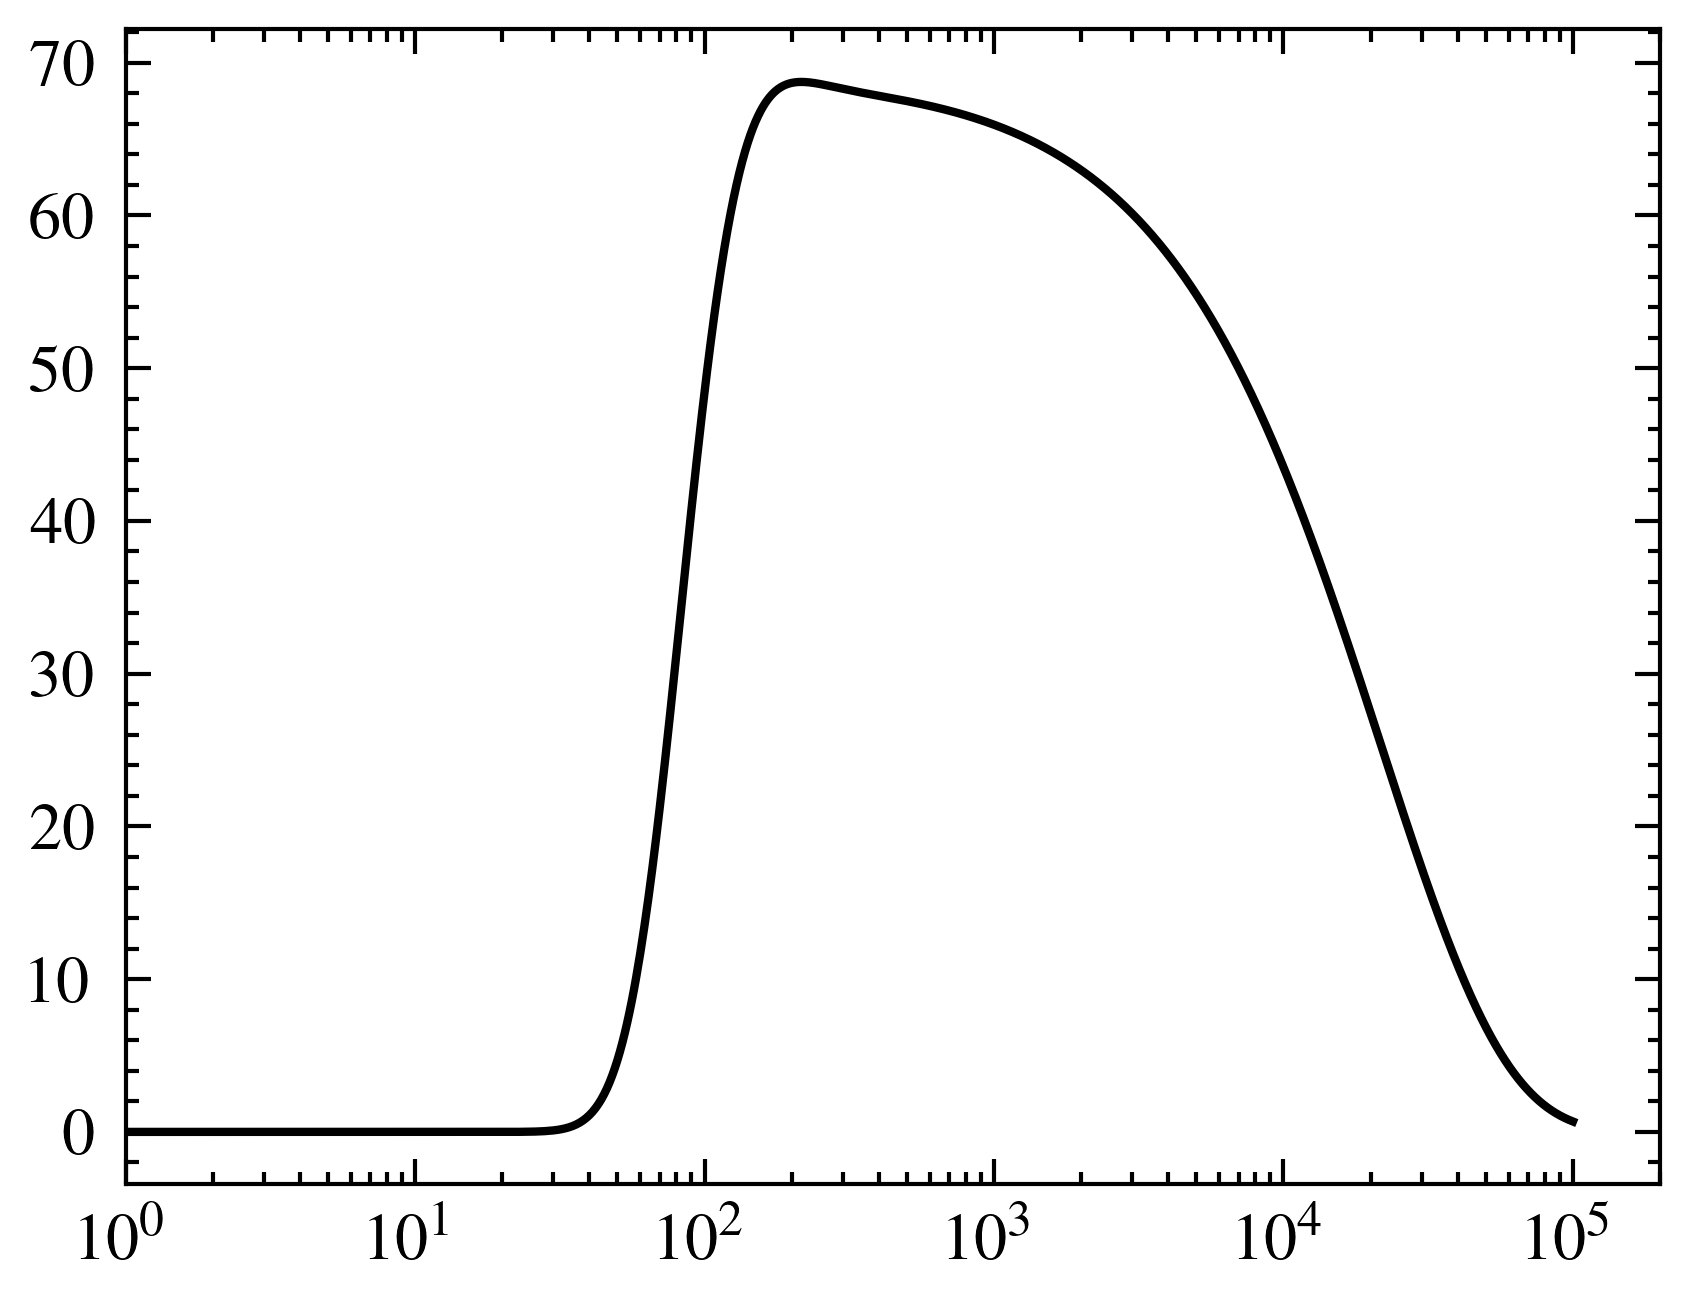

In [40]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(1e-5*sim.rates_evolution[22:, :].sum(axis=0)/cluster_physics.unbiased_jump_rate.magnitude)
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
#plt.yscale('log')
plt.xlim(1,2e5)
plt.xscale('log')
#plt.yscale('log')
#plt.yscale('log')

(100000.0, 10000000000.0)

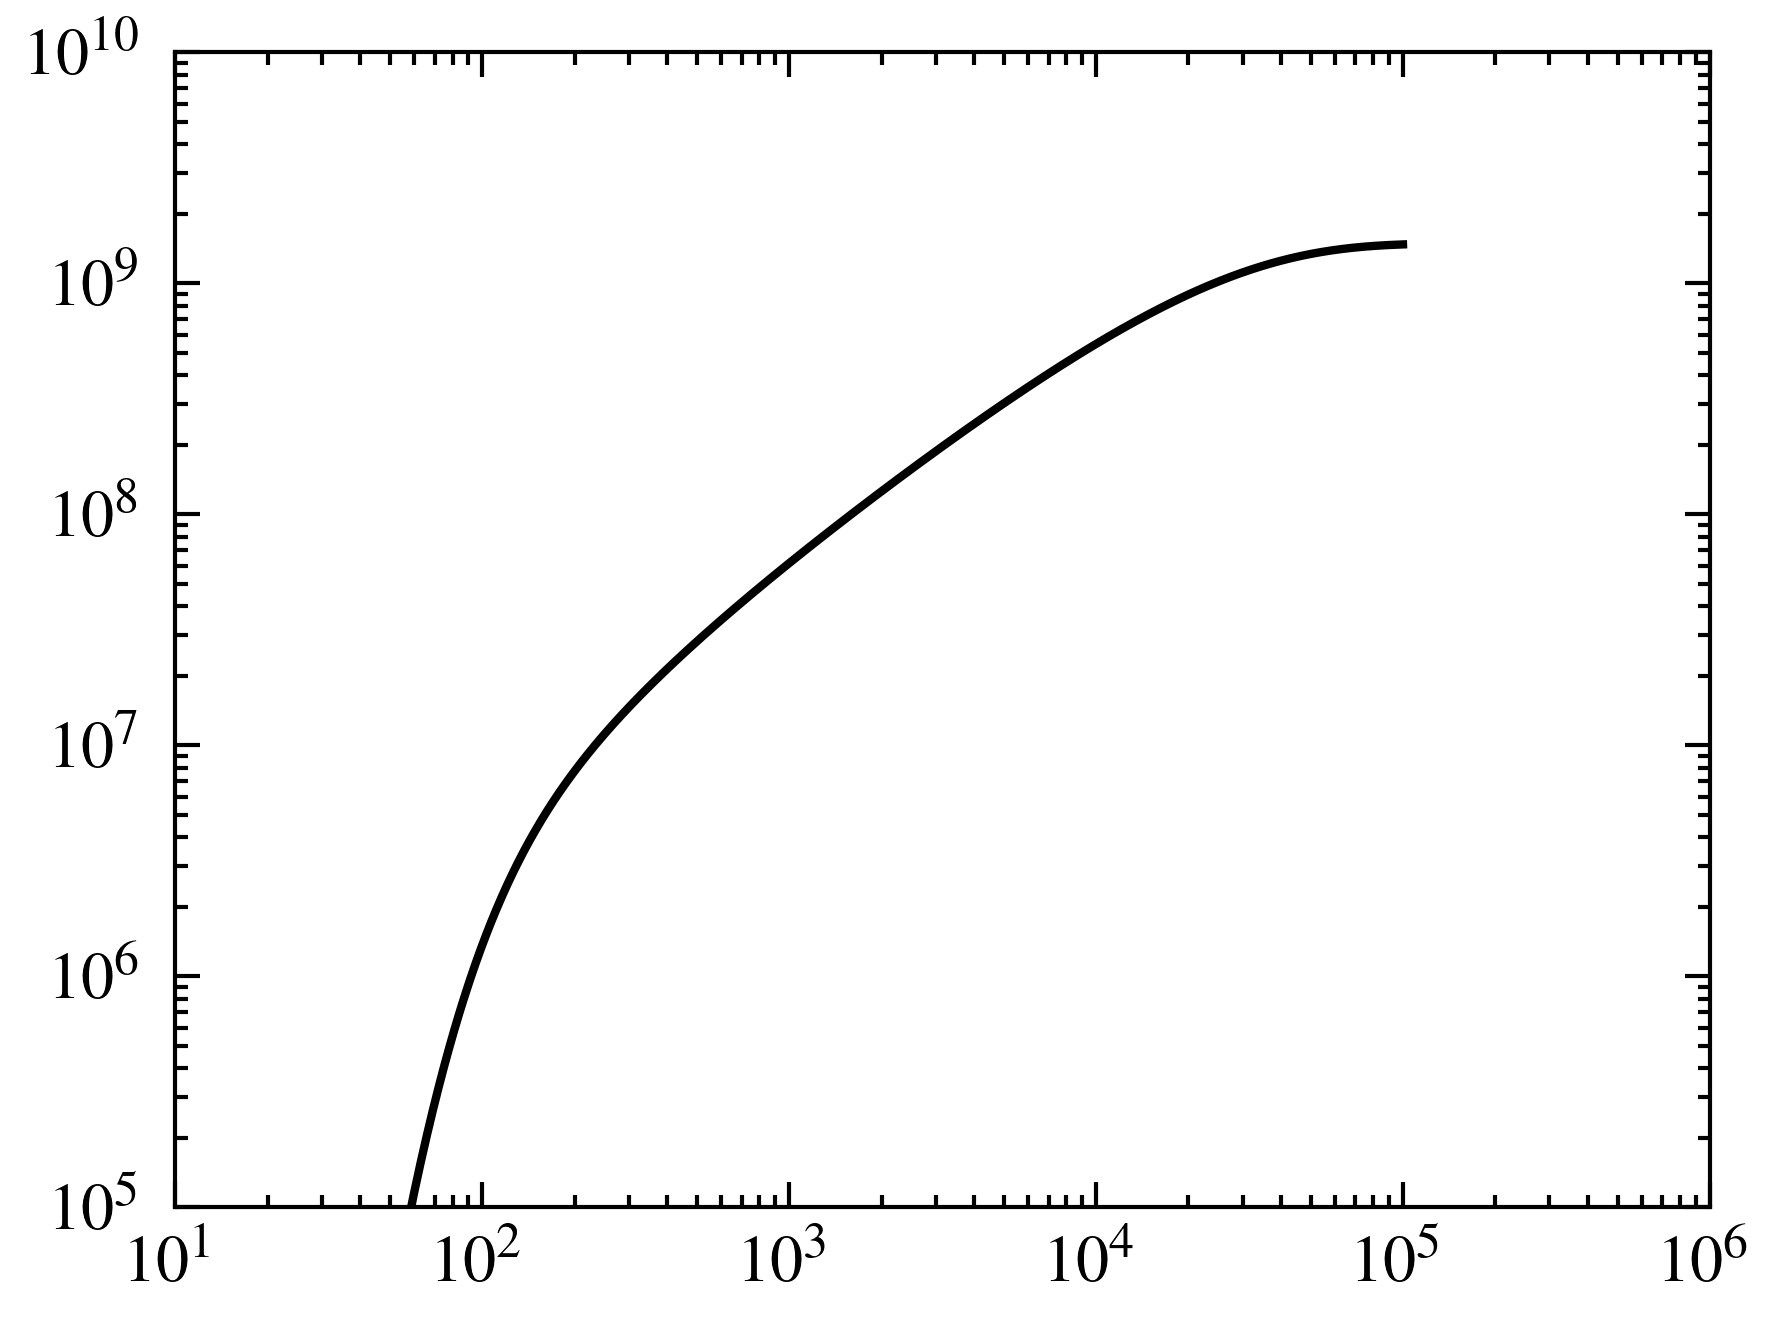

In [41]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.cluster_evolution[22:, :].sum(axis=0))
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e6)
plt.ylim(1e5,1e10)
#plt.yscale('log')
#plt.yscale('log')

In [12]:
suma_t = sim.rates_evolution.sum(axis=0)

# 'suma_t' es ahora un array con la suma de los valores para cada paso de tiempo
print(suma_t)

[4.18813201e-07 4.17950160e-07 4.17088943e-07 ... 8.66019096e-09
 8.64450195e-09 8.62884253e-09]


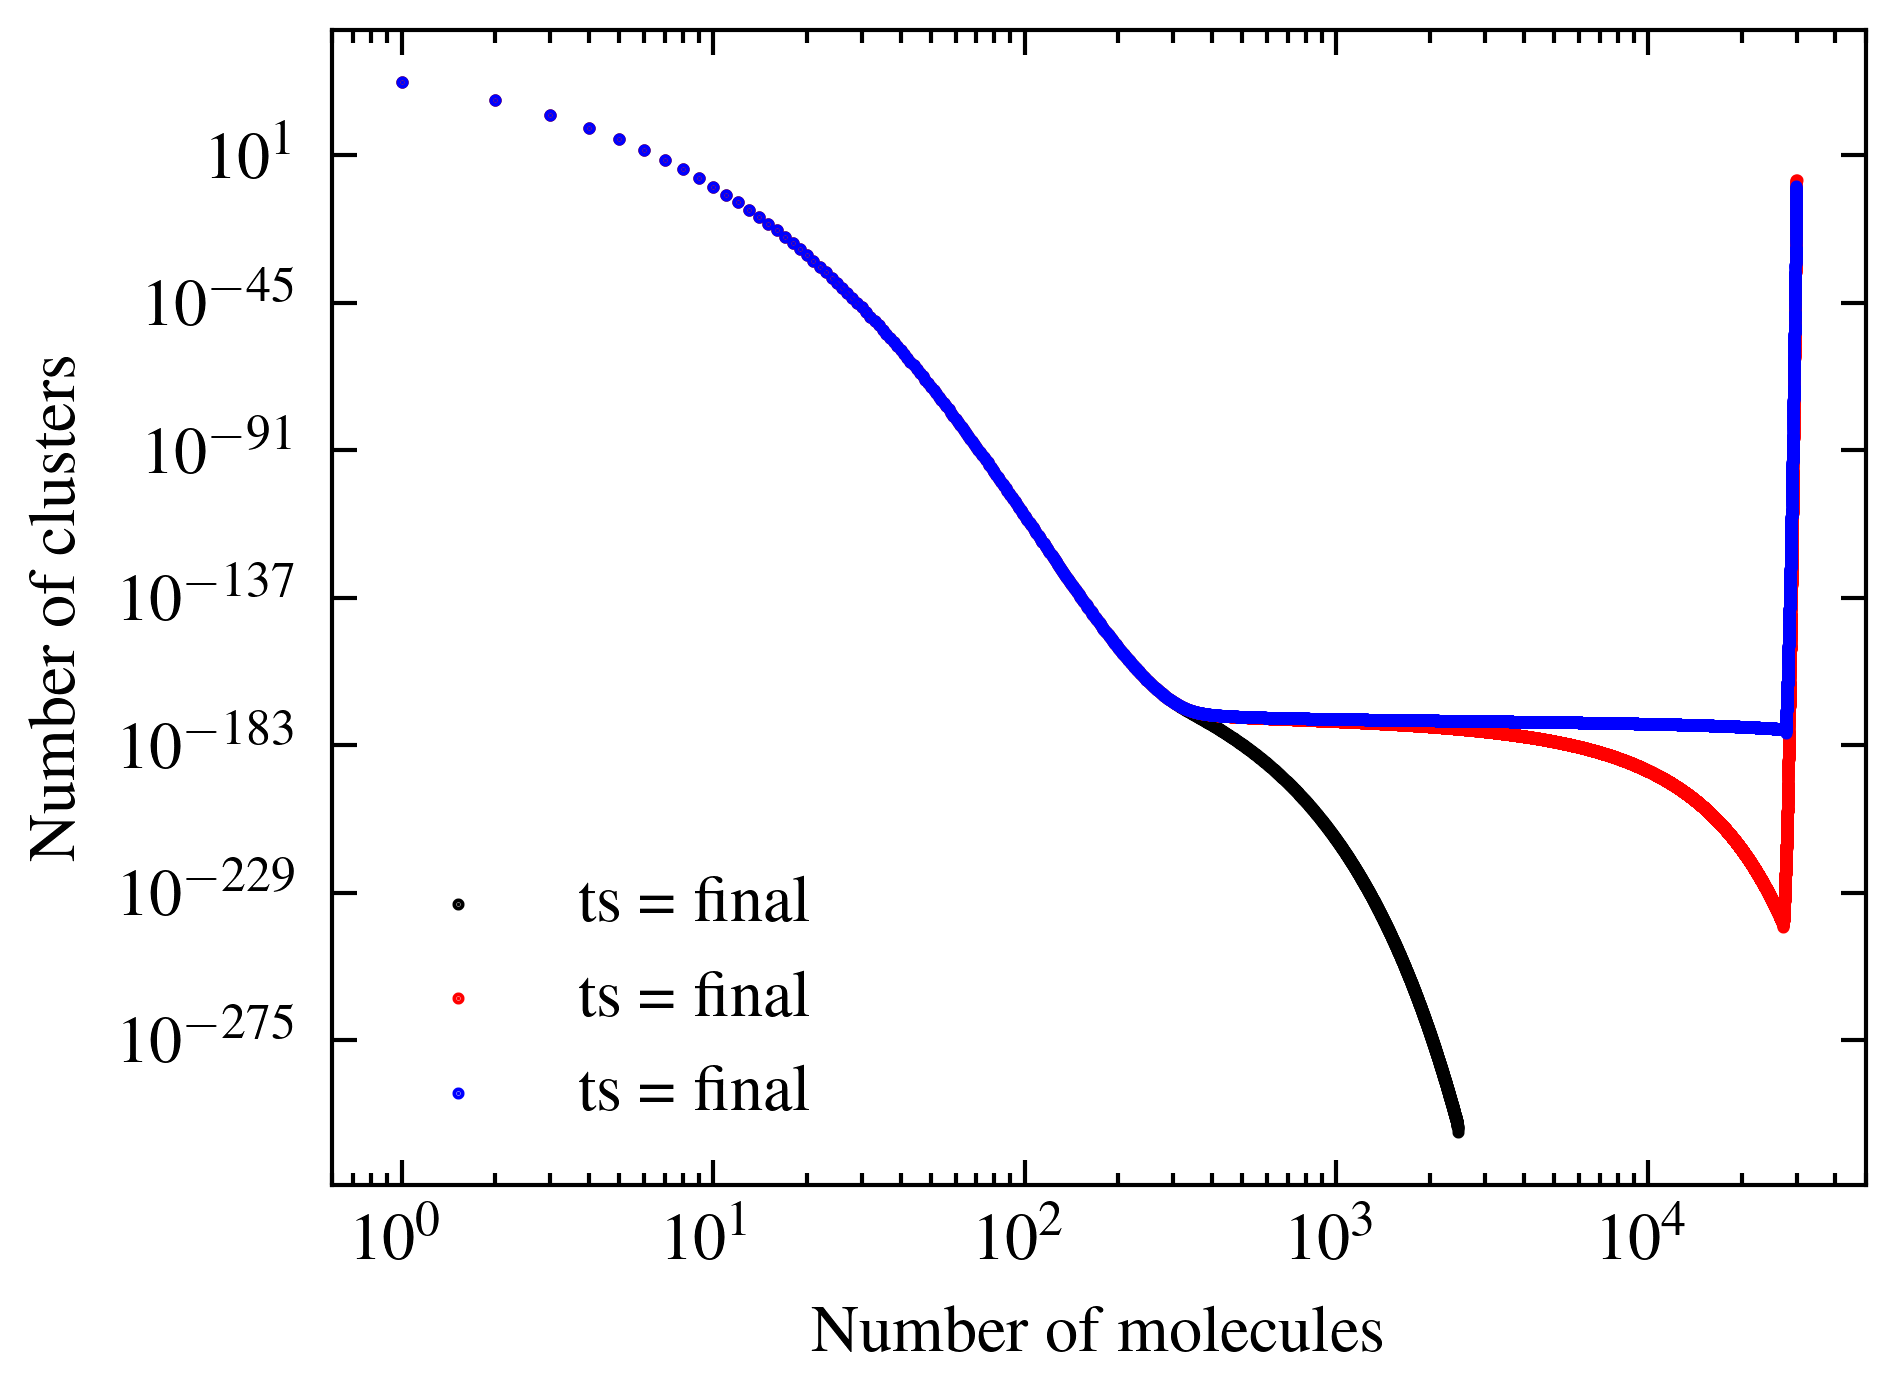

In [73]:
plt.figure()
n = np.linspace(1,500,500)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,10]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,30]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,-1]), label = 'ts = final', s=0.2)
#plt.plot(n,(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xscale('log')
plt.yscale('log')

